In [76]:
import pandas as pd
import numpy as np
from numpy import diff

from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import ternary # ternary plot has a bug
import plotly.express as px
import h5py
import matplotlib as mpl

# import geopandas as gpd
import math

from matplotlib.patches import Circle, Wedge, Polygon

import os
import matplotlib.patheffects as path_effects


from netCDF4 import Dataset as NetCDFFile 

# for beachball - there are some error with using obspy
from pyrocko.plot import beachball
from pyrocko import moment_tensor as ptm

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from pathlib import Path
%matplotlib inline

import harmonica as hm

from obspy.core import UTCDateTime

from datetime import datetime, timezone

import seaborn as sns
sns.set()
sns.set_style(style='white') 
sns.set_style("ticks", {"xtick.major.size": 0.5, "ytick.major.size": 0.5})


#set the font globally
plt.rcParams.update({'font.family':'Helvetica'})

In [77]:
# data = pd.read_csv('sum_with_2005_eqs.csv', header = 'infer')
data = pd.read_csv("/Users/mohd0001/PhD_Monash/Paper2/time-series/data/SUeq_data.csv", header = 'infer')
# data.dtypes

In [78]:
# data = data[(data['MW'] >= 5.1)]

data.sort_values(by = 'MW', ascending = False, inplace = True)

data['DATE'] = pd.to_datetime(data['DATE']) # change dtype to datetime format
data['DATE'] = data['DATE'].dt.strftime('%Y-%m-%d') # change dtype to object

# data['DATE'] and data['TIME'] should be object (str) to perform + operator

data_dummy = np.array(data['DATE'] + ' ' + data['TIME'])

data_ev_time = []

for val in data_dummy:
    data_ev_time.append(UTCDateTime(val))

    
ref_date = data_ev_time[0]

data_ev_time = np.array(data_ev_time)

date = []

for val in data_ev_time:
    date.append(val - ref_date)
    
date = np.array(date) # this is in seconds

data['YEARS'] = date/31536000

df = data.sort_values(by ='YEARS', ascending=True) # this is an important step
# data = data[(data['DATE'] > '01-01-2003') & (data['DATE'] < '26-11-2004')]

In [79]:
df = df[(df['YEARS'] < 5) & (df['YEARS'] > -5)]

from scipy.stats import pearsonr

In [80]:
# Select earthquakes in Java slab at depth greater than 70 km
java_data = df[(df['DEPTH'] > 70) & (df['LAT'] < -2) &
              (df['CLASS'] == "DGOING")]

exp_java = np.asarray(data_java['EX'])
mo_java = np.asarray(data_java['MO'])
time_java = np.asarray(data_java['YEARS'])
energy_java = mo_java*np.power(10., exp_java)
energy_cum_java = np.cumsum(energy_java)

In [81]:
# Select earthquakes in Sumatra megathrus
sumatra_data = df[(df['LAT'] > -2) & (df['LAT'] < 6) &
              (df['CLASS'] == "MTHRUST")]

exp_sumatra = np.asarray(data_sumatra['EX'])
mo_sumatra = np.asarray(data_sumatra['MO'])
time_sumatra = np.asarray(data_sumatra['YEARS'])
energy_sumatra = mo_sumatra*np.power(10., exp_sumatra)
energy_cum_sumatra = np.cumsum(energy_sumatra)

/Users/mohd0001/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mohd0001/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


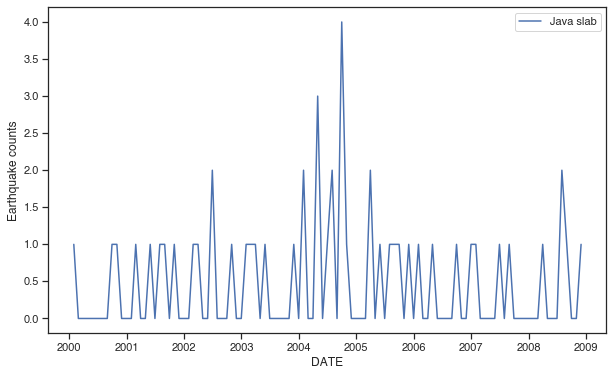

TypeError: unsupported operand type(s) for +: 'float' and 'Timestamp'

In [91]:
# Convert DATE column to DATEtime format
sumatra_data['DATE'] = pd.to_datetime(sumatra_data['DATE'])
java_data['DATE'] = pd.to_datetime(java_data['DATE'])

# Set the time period of interest
start_DATE = '1999-01-01'
end_DATE = '2009-01-01'

# Filter the earthquake data for the time period of interest
sumatra_data_period = sumatra_data.loc[(sumatra_data['DATE'] >= start_DATE) & (sumatra_data['DATE'] < end_DATE)]
java_data_period = java_data.loc[(java_data['DATE'] >= start_DATE) & (java_data['DATE'] < end_DATE)]

# Calculate earthquake counts for Sumatra megathrust and Java slab for the period of interest
sumatra_counts = sumatra_data_period.groupby(pd.Grouper(key='DATE', freq='1M')).size().reset_index(name='Counts')
java_counts = java_data_period.groupby(pd.Grouper(key='DATE', freq='1M')).size().reset_index(name='Counts')

# Plot the earthquake counts for Sumatra megathrust and Java slab for the period of interest
plt.figure(figsize=(10, 6))
# plt.plot(sumatra_counts['DATE'], sumatra_counts['Counts'], label='Sumatra megathrust')
plt.plot(java_counts['DATE'], java_counts['Counts'], label='Java slab')
plt.xlabel('DATE')
plt.ylabel('Earthquake counts')
plt.legend()
plt.show()

# trim the longer list to match the length of the shorter list
min_length = min(len(sumatra_counts), len(java_counts))
sumatra_counts = sumatra_counts[:min_length]
java_counts = java_counts[:min_length]

# calculate Pearson correlation coefficient and p-value
corr, p_val = pearsonr(sumatra_counts, java_counts)
# print("Pearson correlation coefficient: {:.2f}".format(corr))
# print("p-value: {:.4f}".format(p_val))